In [2]:
import pandas as pd
import numpy as np
import itertools 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.feature_selection import SelectKBest


import matplotlib.pyplot as plt

Using TensorFlow backend.


# Change dates, Add Churn, Drop Nans and Dates

In [3]:
def clean_data(df):
    def change_dates(df):
        for column in df.columns:
            if 'date' in column:
                df[column] = pd.to_datetime(df[column], infer_datetime_format = True)
        return df
    
    def drop_dates(df):
        for column in df.columns:
            if 'date' in column:
                df = df.drop(column, 1)
        return df

    df.dropna(inplace = True)
    df = change_dates(df)
    pull_date = pd.to_datetime( "07012014" , format= "%m%d%Y", errors= "coerce")
    churn_date = pull_date - pd.to_timedelta('30 days')
    df['churn'] = df['last_trip_date'] < churn_date
#     df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)
    df = drop_dates(df)
    
    
    return df

# Function to drop specified columns

In [4]:
def drop_columns(df, column_list):
    for column in column_list:
        df = df.drop(column, 1)
    return df

# Normalize Column Function

In [5]:
def normalize_cols(df):
    for col in df.columns:
        if col != 'churn':
            df[col] = (df[col].values - df[col].mean()) / np.std(df[col])
    return df

# Pull in DATA, Clean DATA, Normalize DATA

In [7]:
train_churn = pd.read_csv('churn_train.csv')
test_churn = pd.read_csv('churn_test.csv')
churn = pd.read_csv('churn.csv')

train_churn = clean_data(train_churn)
test_churn  = clean_data(test_churn)
churn       = clean_data(churn)

In [497]:
churn.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', u'trips_in_first_30_days',
       u'luxury_car_user', u'weekday_pct', u'churn', u'city_King's Landing',
       u'city_Winterfell', u'phone_iPhone'],
      dtype='object')

In [498]:
train_churn = normalize_cols(train_churn)
test_churn  = normalize_cols(test_churn)
churn       = normalize_cols(churn)

In [443]:
drop_list = ['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct']

train_churn = drop_columns(train_churn, drop_list)
test_churn  = drop_columns(test_churn, drop_list)
churn       = drop_columns(churn, drop_list)

# TEST/TRAIN, TRUE_TRAIN DATA

In [499]:
y_train = train_churn.pop('churn').values
X_train = train_churn.values

y_test  = test_churn.pop('churn').values
X_test = test_churn.values

y_true_test = churn.pop('churn').values
X_true_test = churn.values


# DEFAULT VALUES DROPPED COLUMNS with NORM

In [500]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print rf.score(X_test, y_test)


gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print gbc.score(X_test, y_test)

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
print ada.score(X_test, y_test)

0.73330927463
0.769637916516
0.763382653675


# TUNING ALL FEATURES

In [510]:
n = 200
n2 = 50
split = 2
leaf  = 5
alpha1 = 0.01
alpha2 = 1.0
rf = RandomForestClassifier(n_estimators = n, 
                            min_samples_split = split, 
                            min_samples_leaf = leaf, 
                            max_depth = 2, 
                            random_state = 1, 
                            verbose = 0)

rf.fit(X_train, y_train)
print rf.score(X_test, y_test)


gbc = GradientBoostingClassifier(n_estimators = n, 
                                 learning_rate = alpha1,
                                 min_samples_split = split, 
                                 min_samples_leaf=leaf, 
                                 max_depth = 2, 
                                 random_state = 1, 
                                 verbose = 0)

gbc.fit(X_train, y_train)
print gbc.score(X_test, y_test)


ada = AdaBoostClassifier(n_estimators = n2, 
                         learning_rate = alpha2, 
                         random_state = 1)

ada.fit(X_train, y_train)
print ada.score(X_test, y_test)

0.705160591844
0.747022735475
0.763382653675


# Neural Net 2 - Train/Test

In [409]:
model = Sequential()
model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)

model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=200, 
          verbose = 1)
score = model.evaluate(X_test, y_test, batch_size=128)

Epoch 1/100
33132/33132 [==============================] - 2s - loss: 0.6165 - acc: 0.6572     
Epoch 2/100
33132/33132 [==============================] - 1s - loss: 0.5793 - acc: 0.7045     
Epoch 3/100
33132/33132 [==============================] - 1s - loss: 0.5676 - acc: 0.7157     
Epoch 4/100
33132/33132 [==============================] - 1s - loss: 0.5637 - acc: 0.7202     
Epoch 5/100
33132/33132 [==============================] - 0s - loss: 0.5571 - acc: 0.7238     
Epoch 6/100
33132/33132 [==============================] - 1s - loss: 0.5542 - acc: 0.7275     
Epoch 7/100
33132/33132 [==============================] - 1s - loss: 0.5517 - acc: 0.7283     
Epoch 8/100
33132/33132 [==============================] - 1s - loss: 0.5500 - acc: 0.7311     
Epoch 9/100
33132/33132 [==============================] - 1s - loss: 0.5486 - acc: 0.7321     
Epoch 10/100
33132/33132 [==============================] - 1s - loss: 0.5459 - acc: 0.7327     
Epoch 11/100
33132/33132 [=============

33132/33132 [==============================] - 0s - loss: 0.5199 - acc: 0.7465     
Epoch 86/100
33132/33132 [==============================] - 0s - loss: 0.5199 - acc: 0.7479     
Epoch 87/100
33132/33132 [==============================] - 0s - loss: 0.5192 - acc: 0.7487     
Epoch 88/100
33132/33132 [==============================] - 0s - loss: 0.5184 - acc: 0.7498     
Epoch 89/100
33132/33132 [==============================] - 0s - loss: 0.5185 - acc: 0.7478     
Epoch 90/100
33132/33132 [==============================] - 0s - loss: 0.5190 - acc: 0.7490     
Epoch 91/100
33132/33132 [==============================] - 0s - loss: 0.5185 - acc: 0.7488     
Epoch 92/100
33132/33132 [==============================] - 0s - loss: 0.5202 - acc: 0.7479     
Epoch 93/100
33132/33132 [==============================] - 0s - loss: 0.5174 - acc: 0.7480     
Epoch 94/100
33132/33132 [==============================] - 1s - loss: 0.5177 - acc: 0.7491     
Epoch 95/100
33132/33132 [=================

In [401]:
ktrain_churn = pd.read_csv('churn_train.csv')
ktest_churn = pd.read_csv('churn_test.csv')
kchurn = pd.read_csv('churn.csv')

ktrain_churn = clean_data(ktrain_churn)
ktest_churn  = clean_data(ktest_churn)
kchurn       = clean_data(kchurn)

ky_train = ktrain_churn.pop('churn').values
kX_train = ktrain_churn.values

ky_test  = ktest_churn.pop('churn').values
kX_test  = ktest_churn.values

ky_true_test = kchurn.pop('churn').values
kX_true_test = kchurn.values


kbest = SelectKBest(k=8)
kbest.fit(kX_train, ky_train)

ind = np.where(kbest.get_support() == True)

kX_train = ktrain_churn[ktrain_churn.columns[ind]].values
ky = ky_train

In [402]:
def get_hist(X, y, node1, node2, epoch):
    model = Sequential()
    model.add(Dense(node1, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(node2, activation='relu'))
    model.add(Dense(len(set(y))-1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
      optimizer='rmsprop',
      metrics=['accuracy'])

    hist = model.fit(X, y, validation_split=0.3,
              epochs=epoch,
              batch_size=128, verbose=0)

    return hist

# GRIDSEARCH 1

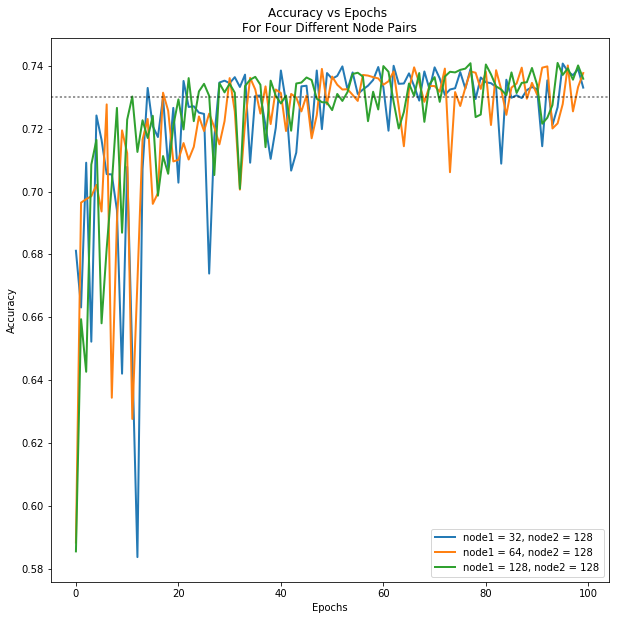

In [406]:
node1 = [32, 64, 128]
node2 = [128]
epoch = 100

fig = plt.figure(figsize = (10, 10))
for nodes in itertools.product(node1, node2):
    nod1  = nodes[0]
    nod2  = nodes[1]
    hist  = get_hist(kX_train, ky_train, nod1, nod2, epoch)
    xaxis = range(len(hist.history['val_acc']))
    arr   = np.array(hist.history['val_acc'])
    plt.plot(xaxis,hist.history['val_acc'],
             linewidth = 2,
             alpha = 1 - (arr.max() - arr.mean()),
             label = 'node1 = {}, node2 = {}'.format(nodes[0], nodes[1]))    
    
plt.axhline(y = 0.73, color = 'k', alpha = 0.4, linewidth = 2, linestyle = 'dotted')    
plt.title('Accuracy vs Epochs \nFor Four Different Node Pairs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# GRIDSEARCH 2

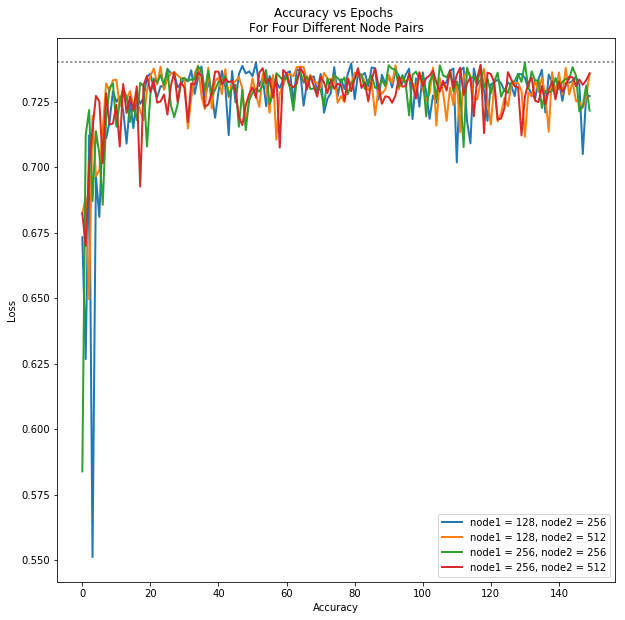

In [407]:
node1 = [128, 256]
node2 = [256, 512]
epoch = 150

fig = plt.figure(figsize = (10, 10))
for nodes in itertools.product(node1, node2):
    nod1  = nodes[0]
    nod2  = nodes[1]
    hist  = get_hist(kX_train, ky_train, nod1, nod2, epoch)
    xaxis = range(len(hist.history['val_acc']))
    arr   = np.array(hist.history['val_acc'])
    plt.plot(xaxis,hist.history['val_acc'],
             linewidth = 2,
             alpha = 1 - (arr.max() - arr.mean()),
             label = 'node1 = {}, node2 = {}'.format(nodes[0], nodes[1]))    
    
plt.axhline(y = 0.74, color = 'k', alpha = 0.4, linewidth = 2, linestyle = 'dotted')    
plt.title('Accuracy vs Epochs \nFor Four Different Node Pairs')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt.show()

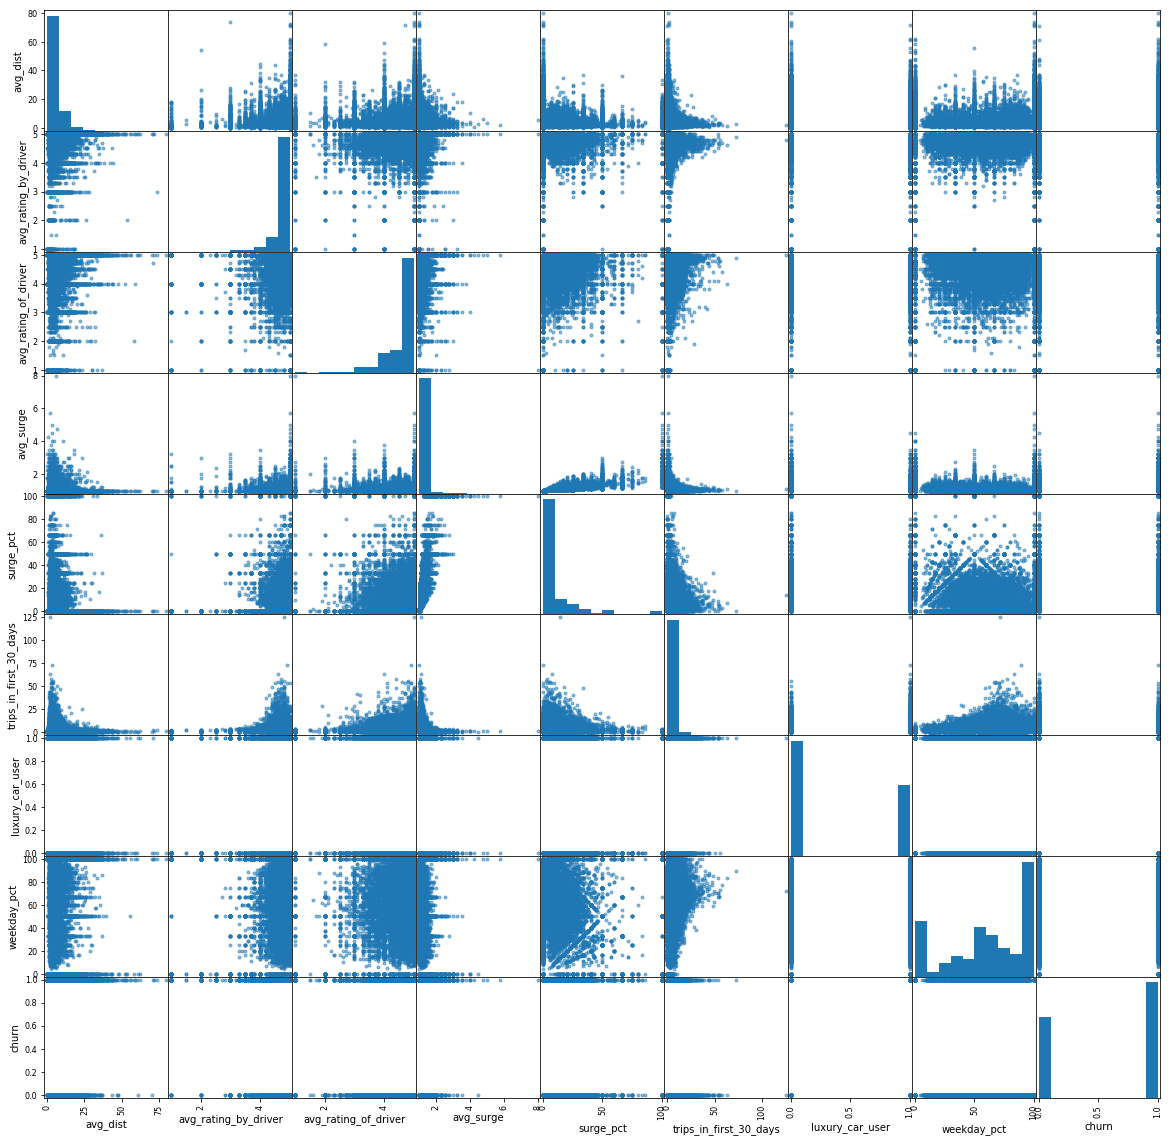

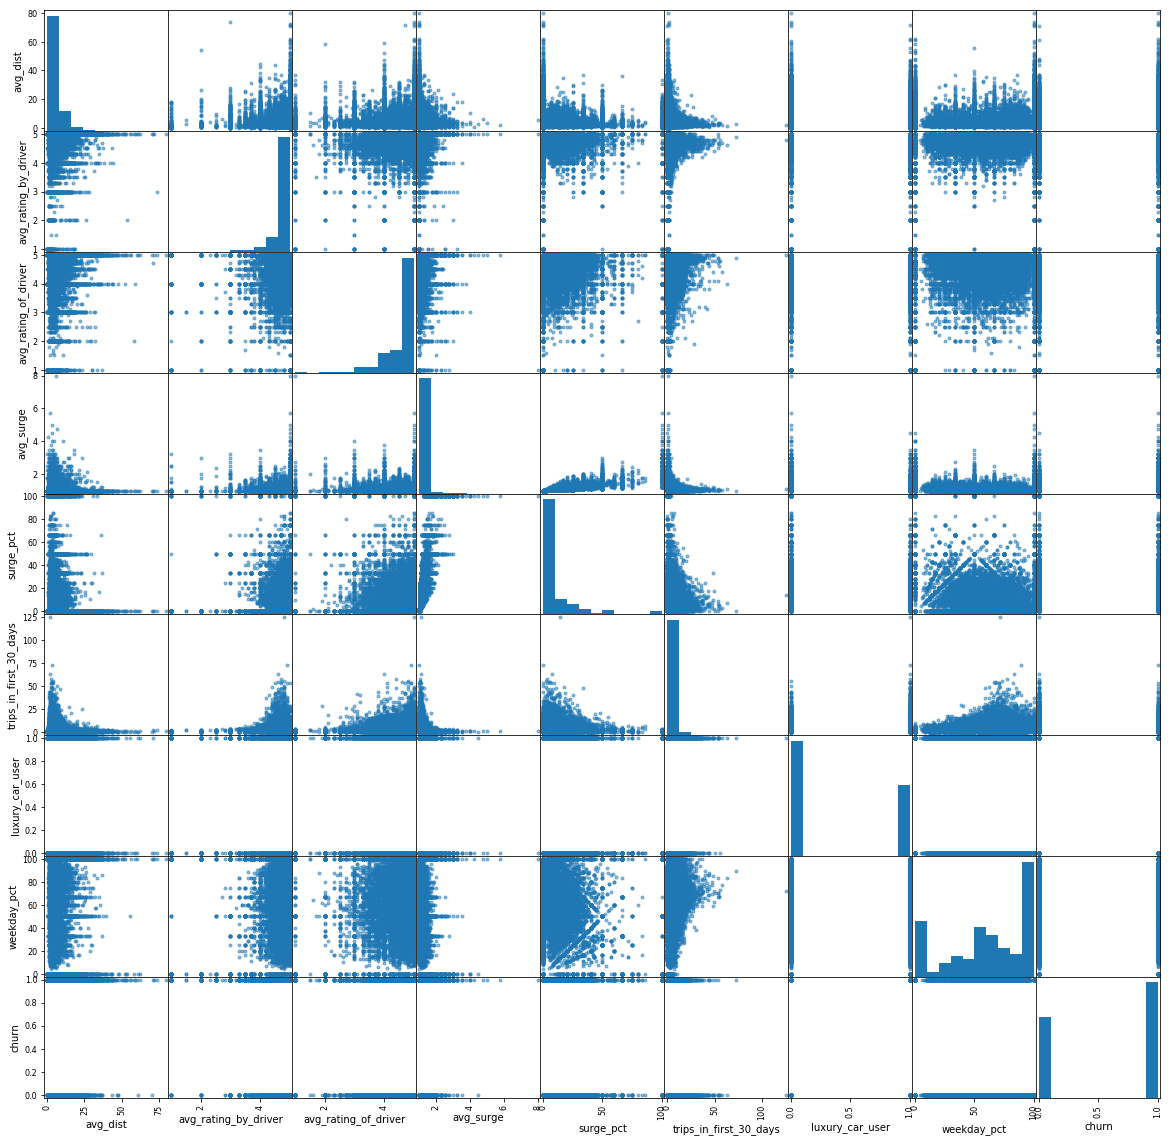

In [9]:
pd.scatter_matrix(train_churn, figsize = (20, 20))
plt.show()